# UNDP Development Minerals 2 Illegal River Extraction Monitoring

<u>Objective 5</u>: Investigate the potential of utilizing remote sensing (RS) and earth observation platforms (EO) to monitor Development Minerals extraction sites. The activity will utilise the Digital Earth Platform and it’s data pipelines to implement a monitoring methodology for detection of changes in the immediate environment of identified extraction sites, and scale up monitoring to a national scale in a phased manner. A unified notebook based on Digtal Earth Pacific infrastructure will be developed and tested using the open data sources identified above, and various processes such NVDI, Water Index, Turbidity Index, Rader Vegetation Index among others will be tested, merged and extrapolated to a create a map product that best demonstrates changes to the waterways and it’s immediate environment due to river extraction. This product will be able to generate impacts maps from 2016 onwards, and previous extraction sites of aggregates will be used as benchmarks and validation testing.

<u>Vectors</u>: <br/>
**Vegetation Change Detection**:      Normalised Difference Vegetation Index (NDVI), Agriculture <br/>
**River/Waterways Change Detection**: Normalised Difference Water Index (NDWI)  <br/>
**Turbidity/Sediment Index**:         Normalised Difference Turbidity Index (NDTI) <br/>

<u>Indicies</u>: <br/>
**NDVI**: (NIR - RED) / (NIR + RED), (B08 - B04) / (B08 + B04) <br/>
**NDWI**: (GREEN - NIR) / (GREEN + NIR) >= 0.3 - Water, < 0.3 - Non-water, (B8A - B11) / (B8A + B11) <br/>
**NDTI**: (RED - GREEN) / (RED + GREEN) , (B04 - B03) / (B04 + BO3) <br/>
**Agriculture**: B11, B08, B02 (SWIR16, NIR, BLUE) 


In [1]:
!pip install -q leafmap
!pip install -q cmocean

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import leafmap
import dask
from dask_gateway import GatewayCluster
from pystac_client import Client
import planetary_computer as pc
import stackstac
import numpy as np
import xarray as xr
import xrspatial.multispectral as ms
import cmocean

### Area and Time Of Interest

In [2]:
local =  gpd.read_file('fiji_river_nakavu.geojson')
time_range = '2021-01-01/2022-12-31'

#AOI Variables
area_of_interest = local.geometry[0]
bbox = local.total_bounds
local.explore()

### Setup Dask Cluster

In [4]:
cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.
client = cluster.get_client()
cluster.adapt(minimum=4, maximum=100)
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.2411bd79cb03461f80456b8f8ecae938/status


### Request Imageries (STAC)

In [5]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest, 
    datetime=time_range,
    limit=100,  
    query={"eo:cloud_cover": {"lt": 10}},
)
items = list(search.get_items())
for item in items:
    print(f"{item.id}: {item.datetime}")
print(f"{len(items)} Images Returned")

S2B_MSIL2A_20220413T221939_R029_T60KXE_20220414T154434: 2022-04-13 22:19:39.024000+00:00
S2A_MSIL2A_20220411T223011_R072_T60KXE_20220412T175923: 2022-04-11 22:30:11.024000+00:00
S2B_MSIL2A_20220403T221939_R029_T60KXE_20220404T081228: 2022-04-03 22:19:39.024000+00:00
S2B_MSIL2A_20220215T223009_R072_T60KXE_20220223T201900: 2022-02-15 22:30:09.024000+00:00
S2A_MSIL2A_20220210T223011_R072_T60KXE_20220221T130112: 2022-02-10 22:30:11.024000+00:00
S2B_MSIL2A_20211114T221939_R029_T60KXE_20211115T065912: 2021-11-14 22:19:39.024000+00:00
S2A_MSIL2A_20210722T221941_R029_T60KXE_20210723T073931: 2021-07-22 22:19:41.024000+00:00
S2B_MSIL2A_20210720T223009_R072_T60KXE_20210721T084527: 2021-07-20 22:30:09.024000+00:00
S2B_MSIL2A_20210717T221939_R029_T60KXE_20210718T061911: 2021-07-17 22:19:39.024000+00:00
S2B_MSIL2A_20210707T221939_R029_T60KXE_20210708T143448: 2021-07-07 22:19:39.024000+00:00
S2B_MSIL2A_20210617T221939_R029_T60KXE_20210618T131432: 2021-06-17 22:19:39.024000+00:00
S2A_MSIL2A_20210516T2

### Sign Images

In [6]:
items = list(search.get_items())
items = [pc.sign(item).to_dict() for item in items]

### Stack Images Into Data (xarray)

In [7]:
data = ( 
        stackstac.stack(items, 
                        bounds_latlon=bbox,
                        assets=["B04", "B03", "B02", "B08", "B11"],  # red, green, blue, nir, swir16
                        chunksize=8192,
                        resolution=10
                       )
        .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
        .assign_coords(
            band=lambda x: x.common_name.rename("band"), # use common names
            time=lambda x: x.time.dt.round("D") #D, MS, 
        )  
       )
data

<xarray.DataArray 'stackstac-7212d820a37129736e9a7343c39879dd' (time: 13,
                                                                band: 5,
                                                                y: 176, x: 246)>
dask.array<where, shape=(13, 5, 176, 246), dtype=float64, chunksize=(1, 1, 176, 246), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2021-04-14...
    id                                       (time) <U54 'S2A_MSIL2A_20210413...
  * band                                     (band) <U6 'red' ... 'swir16'
  * x                                        (x) float64 6.157e+05 ... 6.182e+05
  * y                                        (y) float64 7.99e+06 ... 7.988e+06
    s2:water_percentage                      (time) float64 89.21 75.43 ... 88.3
    ...                                       ...
    proj:bbox                                object {600000.0, 7890220.0, 800...
    gsd                                      (band) int64 10 10 10 10 20
    common_name                              (band) <U6 'red' ... 'swir16'
    center_wavelength                        (band) float64 0.665 0.56 ... 1.61
    full_width_half_max                      (band) float64 0.038 ... 0.143
    epsg                                     int64 32760
Attributes:
    spec:        RasterSpec(epsg=32760, bounds=(615700, 7987760, 618160, 7989...
    crs:         epsg:32760
    transform:   | 10.00, 0.00, 615700.00|\n| 0.00,-10.00, 7989520.00|\n| 0.0...
    resolution:  10

### Define Bands

In [8]:
red = data.sel(band="red")
blue = data.sel(band="blue")
green = data.sel(band="green")
nir = data.sel(band="nir")
swir = data.sel(band="swir16")

### Vector: Agriculture Band Composite

In [9]:
vegetation = data.sel(band=["swir16", "nir", "blue"])

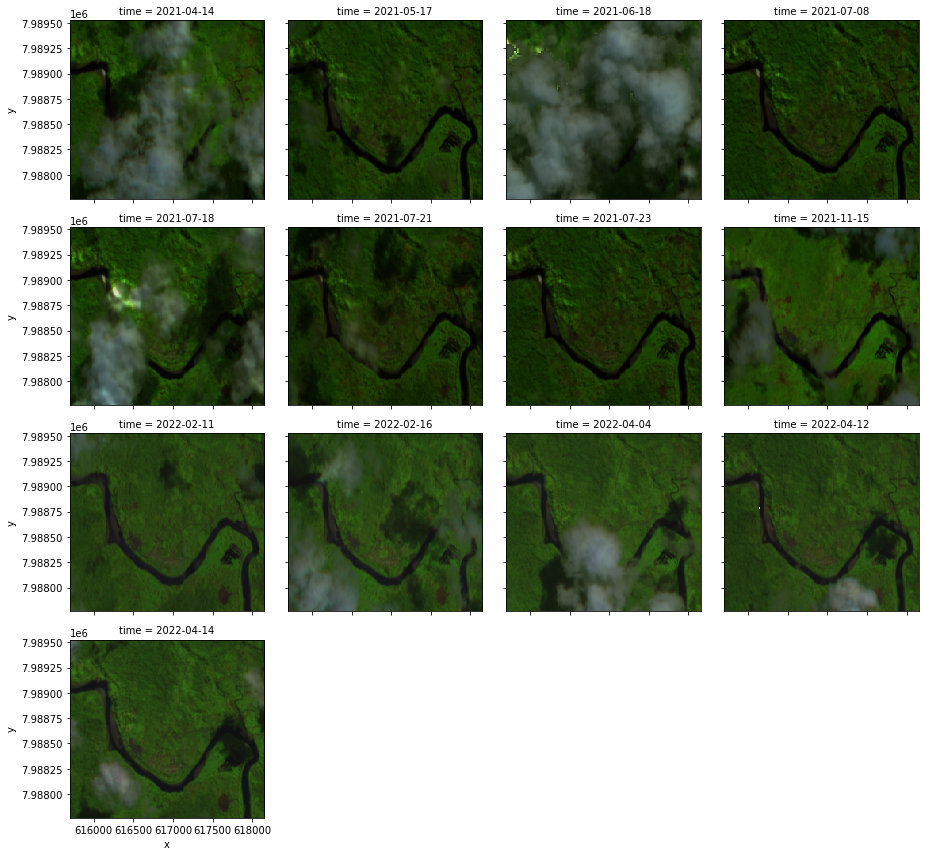

In [10]:
vegetation.plot.imshow(x="x", y="y", col="time", col_wrap=4, cmap="viridis")#.compute()

### Vector: NDVI (Vegetation Index)

In [11]:
ndvi = ((nir - red) / (red + nir)).compute()

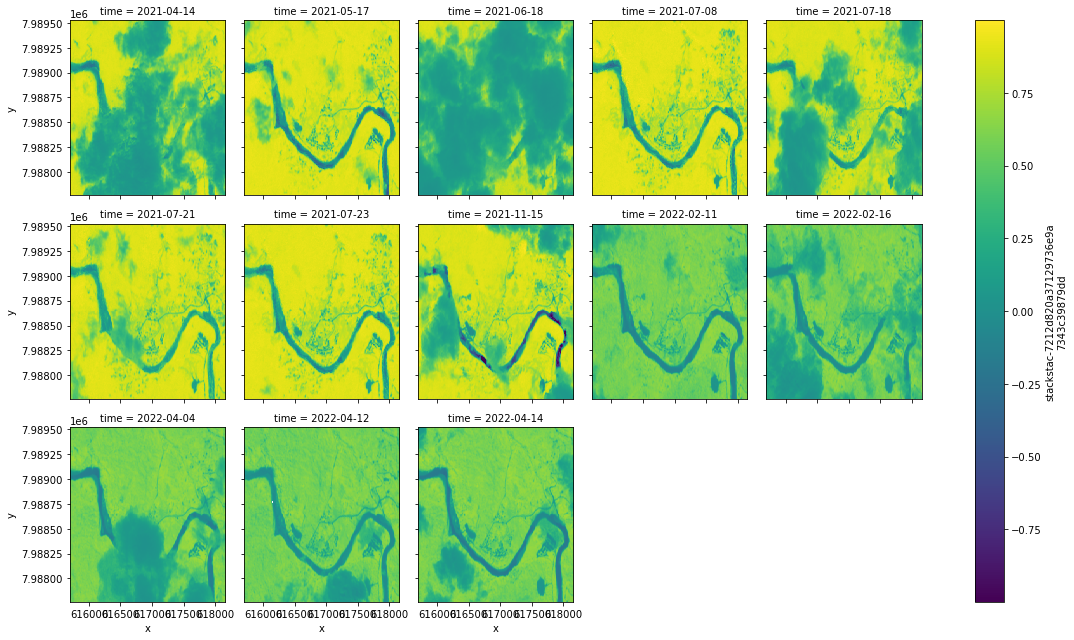

In [12]:
ndvi.plot.imshow(x="x", y="y", col="time", col_wrap=5, cmap="viridis")

### Vector: NDWI (Water Index)

In [13]:
ndwi = ((green - nir) / (green + nir)).compute()

In [14]:
#remove values less then 0.3 
ndwi = ndwi >= 0.0

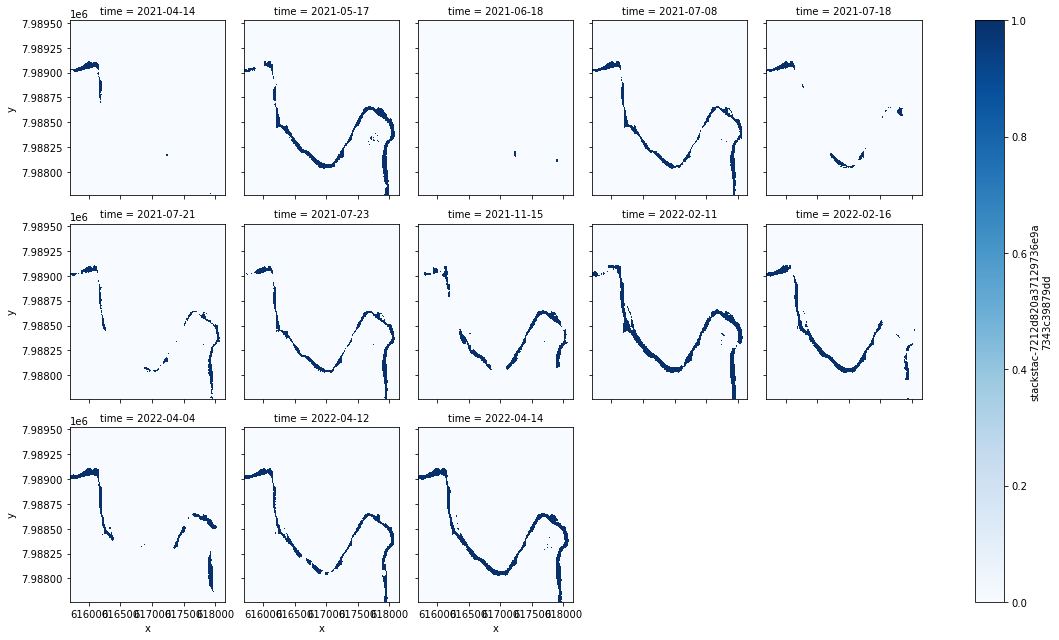

In [15]:
ndwi.plot.imshow(x="x", y="y", col="time", col_wrap=5, cmap="Blues")

### Vector: NDTI (Turbidity Index)

In [16]:
ndti =  ((red - green) / (red + green)).compute()

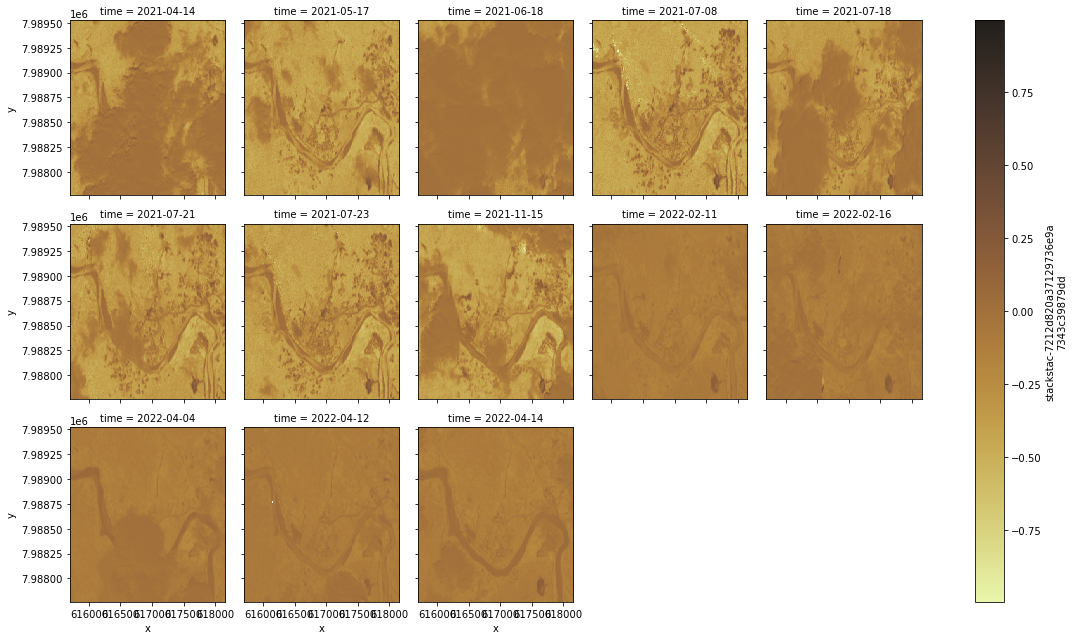

In [17]:
#ndti = ndti >= 0.5
ndti.plot.imshow(x="x", y="y", col="time", col_wrap=5, cmap=cmocean.cm.turbid)

### Change Detection Threshold Definition 
Identification of AOI and DateTime of Extraction

In [18]:
ndvi_change_percent = 0.45
ndwi_change_percent = 0.35
ndti_change_percent = 0.70
vegetation_change_percent = 0.25

In [19]:
#TO BE IMPLEMENTED: 
#Calculating and aligning thresholds of the 4 vectors
#Assigning relevance weigthing to each threshold

### Validation

In [20]:
#Overlaying and verifing previous instances of licenced extraction area and date for Rewa and Navua (data provided by Min.Lands)